### Bayesian linear regression on CPU data

 * #### Aims
     - To implement Bayesian inference over the parameters of the linear model for the CPU data.
     - Practise model selection with marginal likelihood

#### Task 1:  Bayesian treatment of the CPU regression problem
In this task, we will perform a Bayesian treatment of the CPU regression problem. 

#####  We start by loading the data and rescaling it to aid with numerics.

In [1]:
import numpy as np
import pylab as plt
%matplotlib inline
np.random.seed(1)


X_train = np.loadtxt('X_train.csv', delimiter=',', skiprows=1)
X_test = np.loadtxt('X_test.csv', delimiter=',', skiprows=1)
Y_train = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)[:,1][:,None]

MYCT = X_train[:,0][:,None]
MMIN = X_train[:,1][:,None]
MMAX = X_train[:,2][:,None]
CACH = X_train[:,3][:,None]
CHMIN = X_train[:,4][:,None]
CHMAX = X_train[:,5][:,None]

##### Task 1.1: Step up prior, $p(\mathbf{w})$

We'll define a Gaussian prior over $\mathbf{w}$, with mean $\mathbf{0}$ and covariance $\left[\begin{array}{cc} 100& 0\\0 & 5\end{array}\right]$. We'll also fix $\sigma^2=2$.

In [2]:
prior_mean = np.zeros((6,1)) # vector of mean 
prior_cov = np.array([[1,8,1,6,2,9],[4,5,5,5,6,5],[10,1,10,21,10,19],[9,1,1,10,10,10],[10,0,10,0,10,0],[0,20,0,2,10,10]]) # covariance matrix
print(prior_cov.shape)
print(np.linalg.det(prior_cov))
sig_sq = 2 # variance of the additive noise 

(6, 6)
137760.0000000003


##### Task 1.2: Let's see what this prior means by sampling some $\mathbf{w}$ vectors from it and plotting the models with all features
Use `numpy`'s `multivariate_normal` to generate samples from a multivariate Gaussian 
https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html

c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


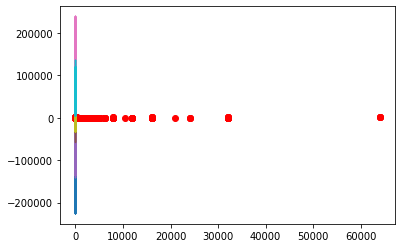

In [3]:
w_samp = np.random.multivariate_normal(prior_mean.flatten(),prior_cov,10) # sampling from multivariate Gaussian distribution 
plt.figure()
plt.plot(X_train,Y_train,'ro') # plot data 
plot_x = X_test # generate new x for plotting the sampled model, e.g. you need construct design matrix for any new x
plt.plot(np.dot(w_samp,plot_x.T).T)

##### Task 1.4: Compute the posterior and draw samples from it

First let's write functions to construct polynomial design matrix, and to compute posterior mean and covariance 
$$\mathbf{\Sigma} = \left(\frac{1}{\sigma^2}\mathbf{X}^{T}\mathbf{X} + \mathbf{S}^{-1}\right)^{-1}$$
$$\boldsymbol\mu = \frac{1}{\sigma^2}\mathbf{\Sigma}\mathbf{X}^{T}\mathbf{t}$$
where $\mathbf{S}$ is the covariance matrix of the prior $p(\mathbf{w})$

In [4]:
def compute_post_cov(X, prior_cov, sig_sq): # your own function to compute posterior mean
    return(np.linalg.inv((1.0/sig_sq)*np.dot(X.T,X) + np.linalg.inv(prior_cov)) )
 
def compute_post_mean(post_cov, sig_sq, X, t): # your own function to compute posterior covariance
    return(np.dot(post_cov,(1.0/sig_sq)*np.dot(X.T,t) ) )

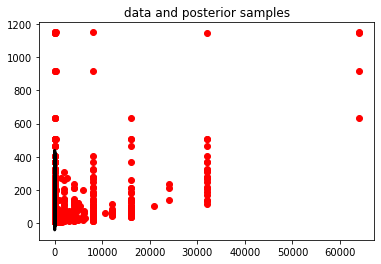

In [5]:
X = X_train # construct design matrix
post_cov = compute_post_cov(X, prior_cov, sig_sq) # compute posterior mean 
post_mean = compute_post_mean(post_cov,sig_sq,X,Y_train) # compute posterior covariance 

plt.figure()
plt.title('data and posterior samples') 
w_samp = np.random.multivariate_normal(post_mean.flatten(),post_cov,1) # draw some samples
plt.plot(X_train,Y_train,'ro')
plt.plot(np.dot(w_samp,X_test.T).T,'b') # plot the sampled lines, 
                                               # only need 2 points to plot a straight line
plt.plot(np.dot(X_test,post_mean),'k',linewidth=3) # plot the posterior mean prediction, 
                                                    # only need 2 points to plot a straight line 



#### Task 2: We'll now look at predictions

##### Task 2.1: Functions for posterior prediction

$$p(t_{new} | \mathbf{X},\mathbf{t},\mathbf{x}_{new},\sigma^2) = {\cal N}(\mathbf{x}_{new}^{T}\boldsymbol\mu,\sigma^2 + \mathbf{x}_{new}^{T}  \mathbf{\Sigma} \mathbf{x}_{new})$$

In [6]:
testX = X_test # generate some test data

pred_mean = np.dot(testX, post_mean) # compute predictive mean
pred_var = sig_sq + np.diag(np.dot(testX,np.dot((post_cov),testX.T))) # compute predictive variance 

#### Task 2.2: Plot error bars 

<ErrorbarContainer object of 3 artists>

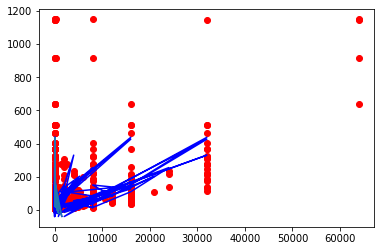

In [7]:
plt.plot(X_train,Y_train,'ro') # plot data 
plt.plot(X_test,pred_mean,'b') # plot mean prediction 
plt.errorbar(X_test[:,0][:,None].flatten(),pred_mean.flatten(),yerr=pred_var.flatten()) # plot error bars 

In [8]:
w_samp = np.random.multivariate_normal(post_mean.flatten(),post_cov,1) 
Y_predict = np.dot(testX,w_samp.T)
print(Y_predict.shape)

(41, 1)


In [9]:
test_header = "Id,PRP"
n_points = X_test.shape[0]
y_pred_pp = np.ones((n_points, 2))
y_pred_pp[:, 0] = range(n_points)
y_pred_pp[:, 1] = Y_predict[:,0]
print(y_pred_pp)
np.savetxt('my_submission_b.csv', y_pred_pp, fmt='%d', delimiter=",",header=test_header, comments="")

[[  0.         134.79254538]
 [  1.         203.17875579]
 [  2.          38.81590856]
 [  3.          31.94144987]
 [  4.         -15.66157272]
 [  5.          39.41540401]
 [  6.         170.87295436]
 [  7.         -40.91821297]
 [  8.         116.50413157]
 [  9.          17.34416161]
 [ 10.          70.92931216]
 [ 11.          31.81293667]
 [ 12.          19.1787906 ]
 [ 13.          74.20023489]
 [ 14.          54.75470749]
 [ 15.          71.73832874]
 [ 16.         425.85842418]
 [ 17.          81.60810541]
 [ 18.         437.27027975]
 [ 19.          62.99217413]
 [ 20.          29.36338668]
 [ 21.         -23.24399389]
 [ 22.          37.88871666]
 [ 23.         144.89768608]
 [ 24.         108.2769934 ]
 [ 25.          83.9324355 ]
 [ 26.         332.25212334]
 [ 27.          16.34498176]
 [ 28.         254.82829797]
 [ 29.         109.37158623]
 [ 30.          13.83539974]
 [ 31.          40.60450958]
 [ 32.          21.50686098]
 [ 33.         126.75881155]
 [ 34.        

#### Task 3: make X_train with 4 features by combining feature

In [10]:
MYCT = X_train[:,0][:,None]
MMIN = X_train[:,1][:,None]
MMAX = X_train[:,2][:,None]
CACH = X_train[:,3][:,None]
CHMIN = X_train[:,4][:,None]
CHMAX = X_train[:,5][:,None]
Average_N_CH = (CHMIN + CHMAX)/2
Average_M_M = (MMIN+MMAX)/2

# allocate new X_train with 4 features
X_new_train = MYCT
X_new_train = np.hstack((X_new_train,Average_M_M))
X_new_train = np.hstack((X_new_train,CACH))
X_new_train = np.hstack((X_new_train,Average_N_CH))
# allocate new Y_train with original Y_train
Y_new_train = Y_train


MYCT_test = X_test[:,0][:,None]
MMIN_test = X_test[:,1][:,None]
MMAX_test = X_test[:,2][:,None]
CACH_test = X_test[:,3][:,None]
CHMIN_test = X_test[:,4][:,None]
CHMAX_test = X_test[:,5][:,None]
Average_N_CH_test = (CHMIN_test + CHMAX_test)/2
Average_M_M_test = (MMIN_test+MMAX_test)/2

# allocate new X_test with 4 features
X_new_test = MYCT_test
X_new_test = np.hstack((X_new_test,Average_M_M_test))
X_new_test = np.hstack((X_new_test,CACH_test))
X_new_test = np.hstack((X_new_test,Average_N_CH_test))

##### Task 1.1: Step up prior, $p(\mathbf{w})$

We'll define a Gaussian prior over $\mathbf{w}$, with mean $\mathbf{0}$ and covariance $\left[\begin{array}{cc} 100& 0\\0 & 5\end{array}\right]$. We'll also fix $\sigma^2=2$.

In [11]:
prior_mean_new = np.zeros((4,1)) # vector of mean 
prior_cov_new = np.array([[1,1,1,2],[4,5,5,1],[1,1,10,1],[1,1,1,10]]) # covariance matrix
print(prior_cov_new.shape)
print(np.linalg.det(prior_cov_new))
sig_sq = 2 # variance of the additive noise 

(4, 4)
72.0


##### Task 1.2: Let's see what this prior means by sampling some $\mathbf{w}$ vectors from it and plotting the models with all features
Use `numpy`'s `multivariate_normal` to generate samples from a multivariate Gaussian 
https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html

c:\users\asus\appdata\local\programs\python\python37-32\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


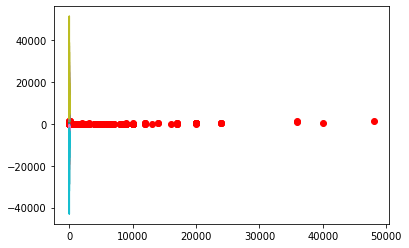

In [12]:
w_samp = np.random.multivariate_normal(prior_mean_new.flatten(),prior_cov_new,10) # sampling from multivariate Gaussian distribution 
plt.figure()
plt.plot(X_new_train,Y_new_train,'ro') # plot data 
plot_x = X_new_test # generate new x for plotting the sampled model, e.g. you need construct design matrix for any new x
plt.plot(np.dot(w_samp,plot_x.T).T)

##### Task 1.4: Compute the posterior and draw samples from it

First let's write functions to construct polynomial design matrix, and to compute posterior mean and covariance 
$$\mathbf{\Sigma} = \left(\frac{1}{\sigma^2}\mathbf{X}^{T}\mathbf{X} + \mathbf{S}^{-1}\right)^{-1}$$
$$\boldsymbol\mu = \frac{1}{\sigma^2}\mathbf{\Sigma}\mathbf{X}^{T}\mathbf{t}$$
where $\mathbf{S}$ is the covariance matrix of the prior $p(\mathbf{w})$

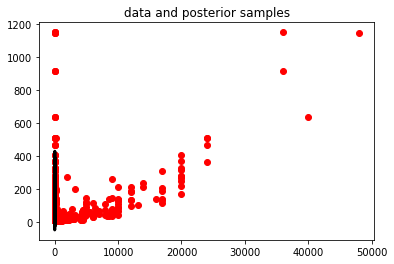

In [13]:
X = X_new_train # construct design matrix
post_cov_new = compute_post_cov(X, prior_cov_new, sig_sq) # compute posterior mean 
post_mean_new = compute_post_mean(post_cov_new,sig_sq,X,Y_new_train) # compute posterior covariance 

plt.figure()
plt.title('data and posterior samples') 
w_samp = np.random.multivariate_normal(post_mean_new.flatten(),post_cov_new,1) # draw some samples
plt.plot(X_new_train,Y_new_train,'ro')
plt.plot(np.dot(w_samp,X_new_test.T).T,'b') # plot the sampled lines, 
                                               # only need 2 points to plot a straight line
plt.plot(np.dot(X_new_test,post_mean_new),'k',linewidth=3) # plot the posterior mean prediction, 
                                                    # only need 2 points to plot a straight line 

#### Task 2: We'll now look at predictions

##### Task 2.1: Functions for posterior prediction

$$p(t_{new} | \mathbf{X},\mathbf{t},\mathbf{x}_{new},\sigma^2) = {\cal N}(\mathbf{x}_{new}^{T}\boldsymbol\mu,\sigma^2 + \mathbf{x}_{new}^{T}  \mathbf{\Sigma} \mathbf{x}_{new})$$

In [14]:
testX = X_new_test # generate some test data

pred_mean_new = np.dot(testX, post_mean_new) # compute predictive mean
pred_var_new = sig_sq + np.diag(np.dot(testX,np.dot((post_cov_new),testX.T))) # compute predictive variance 

#### Task 2.2: Plot error bars 

<ErrorbarContainer object of 3 artists>

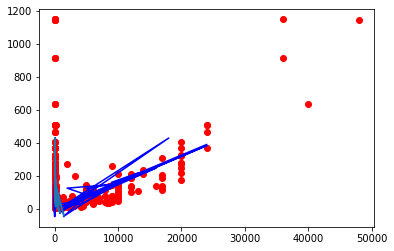

In [15]:
plt.plot(X_new_train,Y_new_train,'ro') # plot data 
plt.plot(X_new_test,pred_mean_new,'b') # plot mean prediction 
plt.errorbar(X_new_test[:,0][:,None].flatten(),pred_mean_new.flatten(),yerr=pred_var_new.flatten()) # plot error bars 

In [16]:
w_samp = np.random.multivariate_normal(post_mean_new.flatten(),post_cov_new,1) 
Y_predict_new = np.dot(X_new_test,w_samp.T)
print(Y_predict_new.shape)

(41, 1)


In [17]:
test_header = "Id,PRP"
n_points = X_new_test.shape[0]
y_pred_pp_new = np.ones((n_points, 2))
y_pred_pp_new[:, 0] = range(n_points)
y_pred_pp_new[:, 1] = Y_predict_new[:,0]
print(y_pred_pp_new)
np.savetxt('my_submission_new_b.csv', y_pred_pp_new, fmt='%d', delimiter=",",header=test_header, comments="")

[[  0.         161.03510482]
 [  1.         217.17255895]
 [  2.          49.71911817]
 [  3.          37.9461093 ]
 [  4.         -13.49158657]
 [  5.          52.30598686]
 [  6.         171.72953995]
 [  7.         -46.26329305]
 [  8.         131.2223331 ]
 [  9.          13.7988076 ]
 [ 10.          80.62255498]
 [ 11.          24.13394452]
 [ 12.          12.71482766]
 [ 13.          71.40412429]
 [ 14.          48.8100178 ]
 [ 15.          70.21858354]
 [ 16.         383.93855524]
 [ 17.          97.80697557]
 [ 18.         390.99497201]
 [ 19.          75.48018803]
 [ 20.          28.73469752]
 [ 21.         -26.14260448]
 [ 22.          41.97662   ]
 [ 23.         151.08603555]
 [ 24.         124.66115876]
 [ 25.          85.46994966]
 [ 26.         429.27046835]
 [ 27.          15.64416485]
 [ 28.         247.68983984]
 [ 29.         128.66889243]
 [ 30.          26.96563666]
 [ 31.          40.24478466]
 [ 32.          25.50749326]
 [ 33.         148.30662017]
 [ 34.        